# Regularización

La regularización es una forma de condicionar nuestra función objetivo de cara a evitar un sobre-entrenamiento del modelo. Aplanando los coeficientes de nuestra regresión original ($y = c_1x + c_0$) de cara a que no resulten valores extremadamente ajustados a la curva de los datos de muestra empleados para el entrenamiento.

![overfit](./img/overfit.png)


Tened en cuenta que nosotros observamos el mundo por un agujero, el que nos dejan ver nuestras muestras. Pero nuestro modelo debe ser capaz de hacer inferencias sobre el total.

Los modelos de regularización más comunes son:

* **Ridge** que emplea la norma **L2** enfocada en aplanar los coeficientes de nuestro modelo (sensible a valores atípicos).

Partiendo de una función de coste $\sum^M(y - \hat{y})^2$ siendo $\hat{y} = c_1x + c_0$ amplía esta expresión añadiendo la penalización $\lambda \sum^N c_i^2$ donde $\lambda$ es un coeficiente de cómo de estrictos queremos ser en la regularización. De este modo, nuestro modelo Ridge representaría la fórmula:

$$

\sum^M(y - (c_1x + c_0))^2 + \lambda \sum^N c_i^2

$$


* **Lasso** (acrónimo de _Least Absolute Shrinkage and Selection Operator_) que emplea la norma **L1** enfocada en eliminar aquellos coeficientes asociados a variables con _poca_ relevancia. Esto extiende el caso anterior a la siguiente forma:


$$

\sum^M(y - (c_1x + c_0))^2 + \lambda \sum^N |c_i|

$$


* **Elastic Net** que combina ambos casos anteriores.

### Predicción de cáncer de próstata

Tomaremos como ejemplo para nuestros ejercicios unas muestras de 97 hombres con cancer de próstata. Queremos centrarnos en entender la relación entre el antígeno prostático específico (psa) el cual es elevado en casos positivos. El resto de variables serán medidas empleadas para la detección y predicción de los valores asociados con el PSA.

Disponemos de 9 variables:
* lcavol: logaritmo del volumen del cancer
* lweight: log peso próstata
* age: edad del paciente en años
* lbph: log cantidad de hyperplasia prostática benigna
* svi: invasion de la vesícula seminal
* lcp: log penetración capsular
* gleason: puntuación Gleason
* pgg45: porcentaje de la puntuación de Gleason en 4 o 5
* lpsa: log antígeno prostático específico 

#### Modelos

Los datos vienen representados por $n$ puntos en $p$ dimensiones, por lo tanto las variables predictivas existen en $X\in\mathbb{R}^{n\times p}$ mientras que la respuesta objetivo en $y\in\mathbb{R}^n$.

Compararemos los resultados de la regresión linean base con sus potenciales mejoras: **Ridge regression**, **Lasso** y **Elastic Net**.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns

## Exploración de los datos

In [1]:
import pandas as pd

lpsa_data = pd.read_csv('data/prostate_dataset.txt', delimiter='\t')
lpsa_data = lpsa_data.loc[:, 'lcavol':]
lpsa_data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


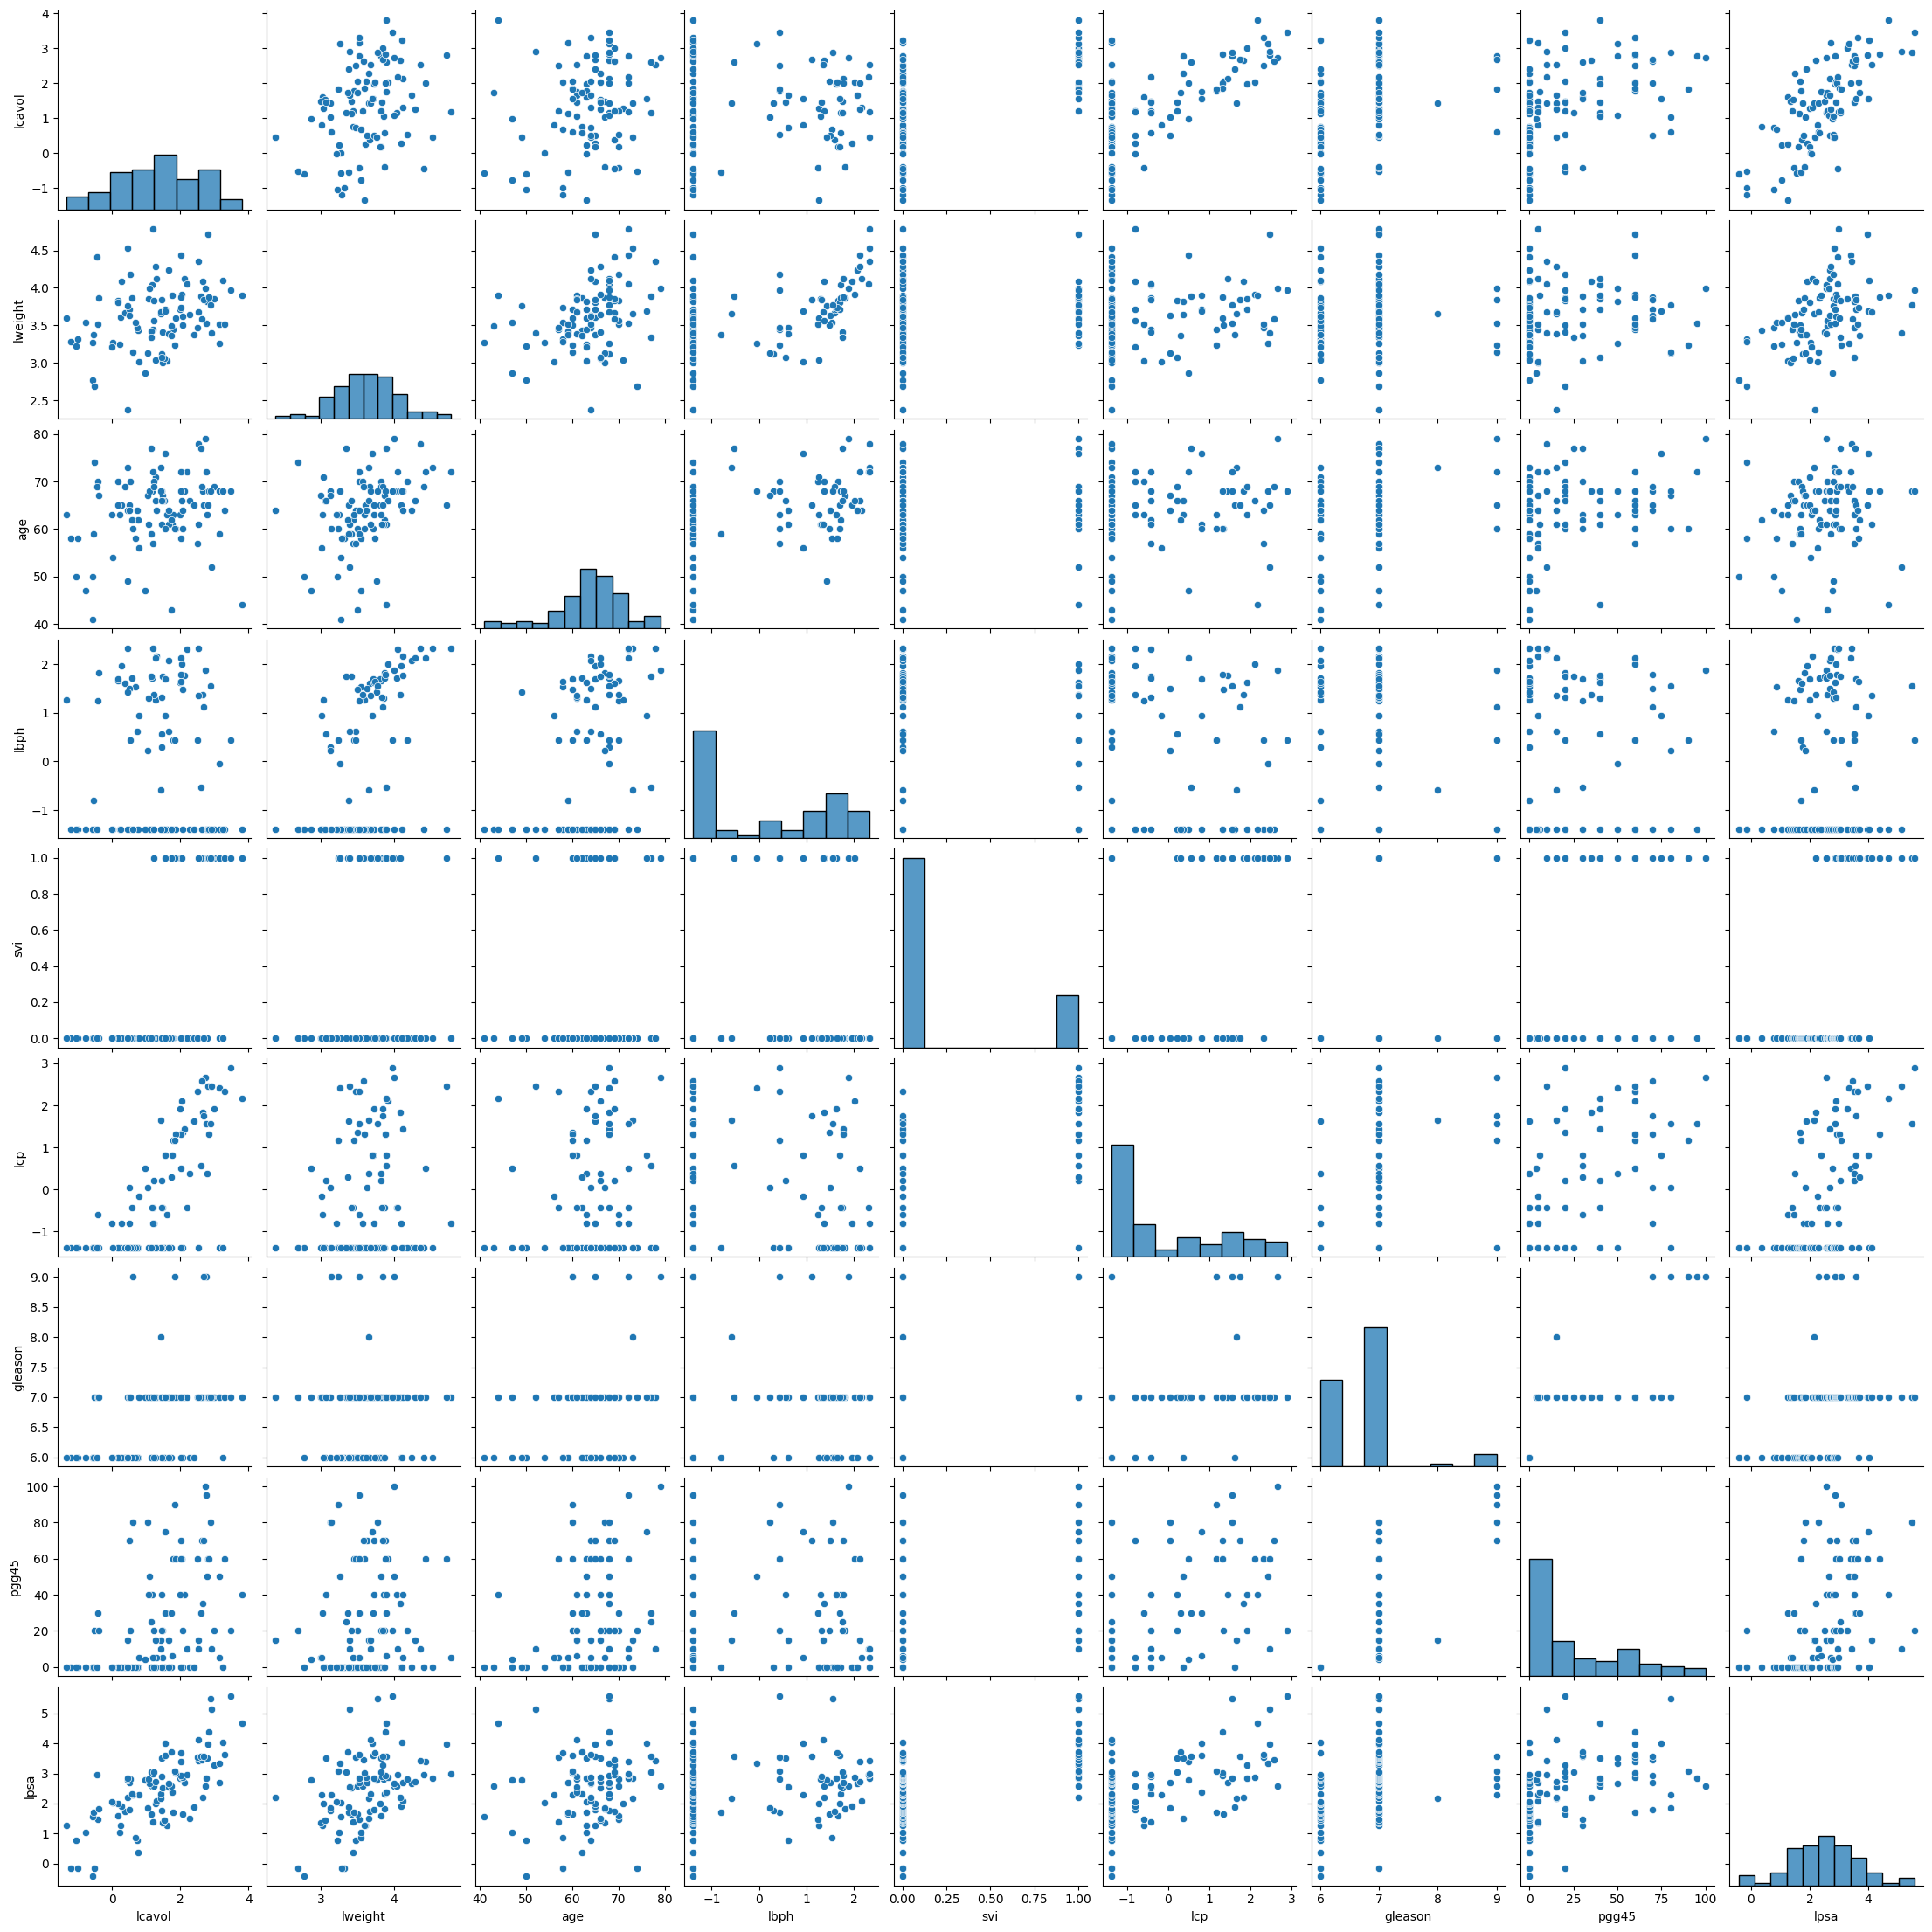

In [3]:
import seaborn as sns

sns.pairplot(lpsa_data);

* lpsa parece presentar un distribución normal.
* svi es de carácter binario
* lcp: parece que por errores en la medición o sesgos a la hora de medir los valores pequeños se han corregido a -1.25 de manera fija
* gleason y pgg45 no parecen estar correladas...

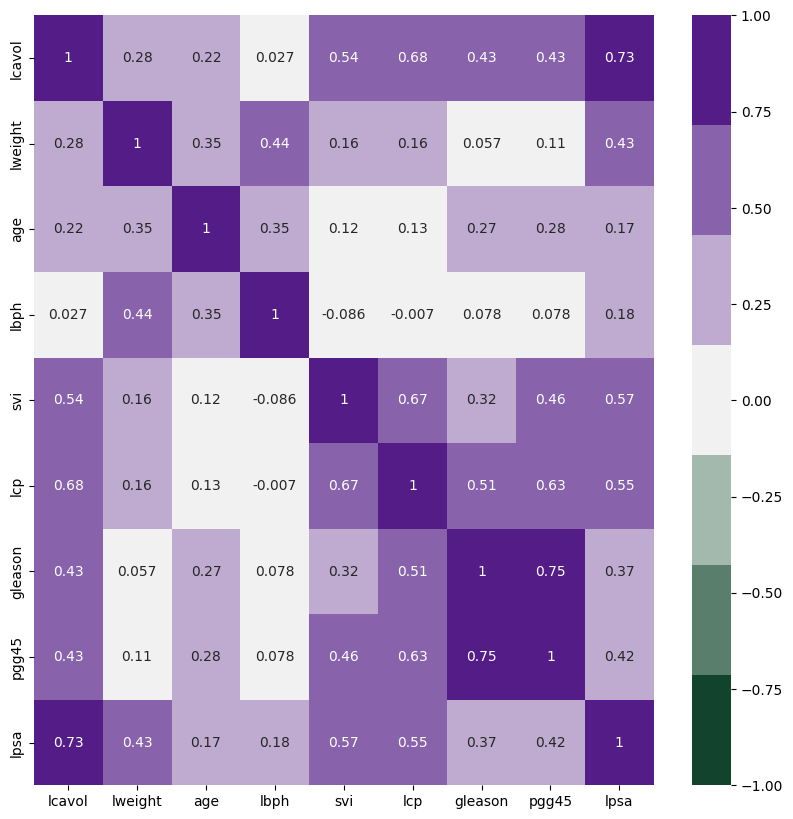

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.heatmap(lpsa_data.corr(),
           vmin=-1,
           vmax=1,
           cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
           annot=True);

* lcavol parece la variable más correlada con lpsa. Deberíamos por lo tanto emplearla en nuestro modelo.

* Resulta que gleason y pgg45 si que están altamente correladas.

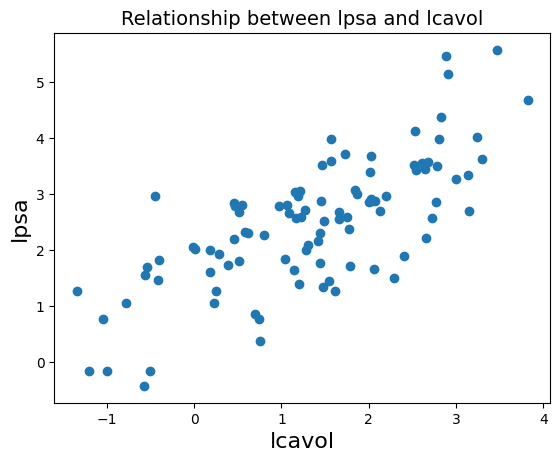

In [6]:
plt.scatter(lpsa_data['lcavol'], lpsa_data['lpsa'])
plt.xlabel('lcavol', fontsize=16)
plt.ylabel('lpsa', fontsize=16)
plt.title("Relationship between lpsa and lcavol", fontsize=14)
plt.show()

Queda claro que hay una relación directa, correlación positiva significativa, entre ambas variables.

In [7]:
lpsa_data.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


Vamos a separar los datos de forma manual en lugar de emplear funciones de Scikit-learn (por practicar).

In [8]:
muestras_totales = 97
muestras_entrenamiento = 60

In [10]:
# Features
X_train = lpsa_data.iloc[:muestras_entrenamiento,0:-2] # eliminamos pgg45
X_test = lpsa_data.iloc[muestras_entrenamiento:,0:-2]

# Target
y_train = lpsa_data.iloc[:muestras_entrenamiento,-1] # lpsa
y_test = lpsa_data.iloc[muestras_entrenamiento:,-1]  # lpsa

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60, 7)
(37, 7)
(60,)
(37,)


## Modelos


#### Regresión lineal

[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [13]:
from sklearn import linear_model, metrics

lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
baseline_error = metrics.mean_squared_error(y_test, y_pred)

print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))

Train MSE: 0.2877748864599949
Test MSE: 2.8641499657014413


### Regresión de ridge

[Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [17]:
from sklearn.linear_model import Ridge

# lambda -> alpha
ridgeR = Ridge(alpha = 0.001)
ridgeR.fit(X_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)),2))
print("-"*50)
print("Train MSE con regularización:", round(metrics.mean_squared_error(y_train, ridgeR.predict(X_train)),2))
print("Test MSE con regularización:", round(metrics.mean_squared_error(y_test, ridgeR.predict(X_test)),2))

Train MSE sin regularización: 0.29
Test MSE sin regularización: 2.86
--------------------------------------------------
Train MSE con regularización: 0.29
Test MSE con regularización: 2.86


Parece que no hay mucha mejora, quizás se deba a que nuestro peso de regularización no es muy fuerte. Probemos con varios.

In [19]:
import numpy as np

n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas)

print(f"Variaremos los valores entre {np.min(alphas)} y {np.max(alphas)}")

Variaremos los valores entre 0.0001 y 1000.0


In [20]:
coef_ridge = []
err_ridge = []
baseline = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    
    coef_ridge.append(ridge.coef_)
    
    y_pred = ridge.predict(X_test)
    ridge_error = metrics.mean_squared_error(y_pred, y_test)
    
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

In [21]:
print(f"Hemos obtenido un valor mínimo de {min(err_ridge)}")

Hemos obtenido un valor mínimo de 2.0650575013210712


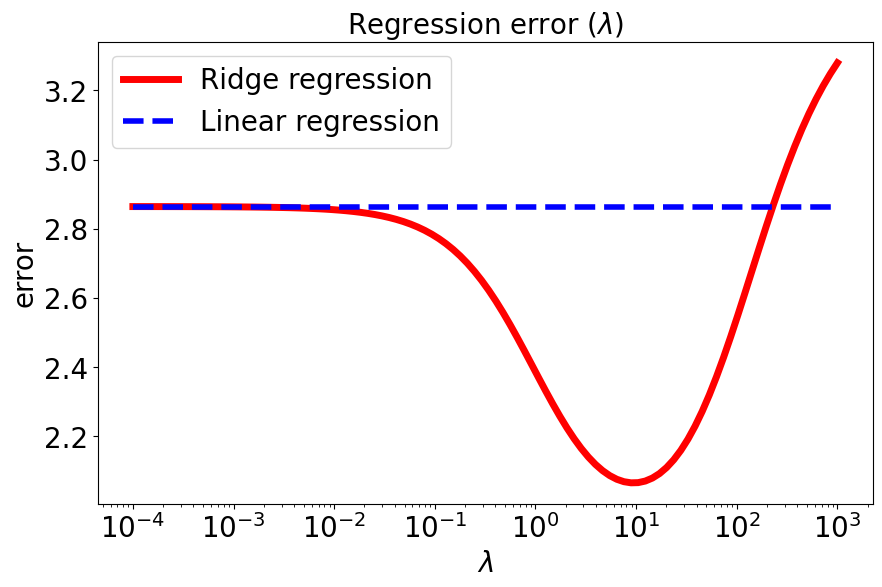

In [23]:
plt.figure(figsize=(10,6))
font = 20

ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.ylabel('error', fontsize=font)
ax.legend(fontsize=font)
plt.title(r'Regression error ($\lambda$)', fontsize=font)
plt.show()

In [24]:
from sklearn.linear_model import Ridge 
  
# Train the model  
ridgeR = Ridge(alpha = 10) 
ridgeR.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, ridgeR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, ridgeR.predict(X_test)))

Train MSE: 0.3160
Test MSE: 2.0651


* El valor que mejor resulta parece ser alrededor de 10 para $\lambda$.
* Si $\lambda \to 0$ los resultados son similares a los de la regresión lineal.
* Si $\lambda \to \infty$, la regularización domina a la parte de función objetivo.

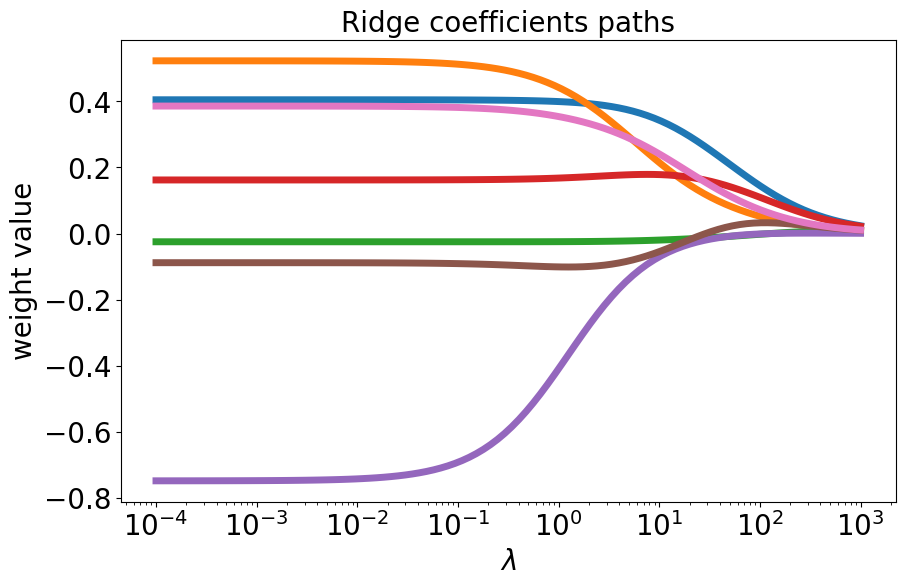

In [25]:
plt.figure(figsize=(10,6))

ax = plt.gca()
ax.plot(alphas, coef_ridge, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.ylabel('weight value', fontsize=font)
plt.title('Ridge coefficients paths', fontsize=font)
plt.show()

Podemos ver cómo la regularización restringe el rango de los valores asociados a cada variable independiente.

## Lasso

[Lasso](https://scikit-learn.org/stable/modules/linear_model.html#lasso)

In [27]:
from sklearn.linear_model import Lasso

lassoR = Lasso(alpha=0.1)
lassoR.fit(X_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)),2))
print("-"*50)
print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test)))

Train MSE sin regularización: 0.29
Test MSE sin regularización: 2.86
--------------------------------------------------
Train MSE: 0.3740
Test MSE: 2.0788


In [28]:
lasso = Lasso(fit_intercept=False) # No ajustar el c0

coef_lasso = []
err_lasso = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coef_lasso.append(lasso.coef_)
    y_pred = lasso.predict(X_test)
    lasso_error = metrics.mean_squared_error(y_pred, y_test)    
    err_lasso.append(lasso_error)

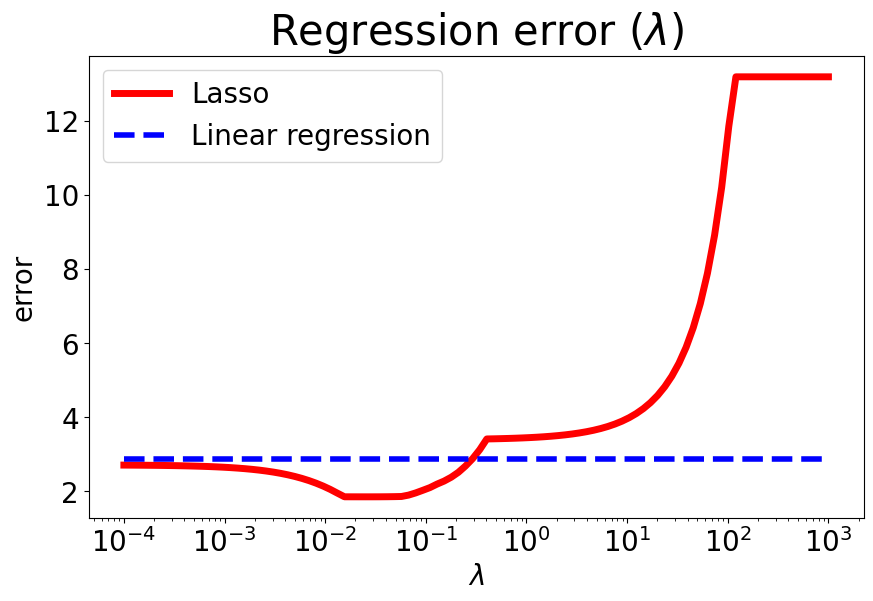

In [29]:
plt.figure(figsize=(10,6))

ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="Lasso")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.ylabel('error', fontsize=font)
ax.legend(fontsize=font)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [30]:
lassoR = Lasso(alpha = 0.02) 
lassoR.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test)))

Train MSE: 0.3061
Test MSE: 1.8514


In [31]:
print("Test MAPE: %0.4f" % metrics.mean_absolute_percentage_error(y_test, lassoR.predict(X_test)))

Test MAPE: 0.3103


* El valor óptimo para $\lambda$ se encuentra entre $10^{-2}$ y $10^{-1}$.

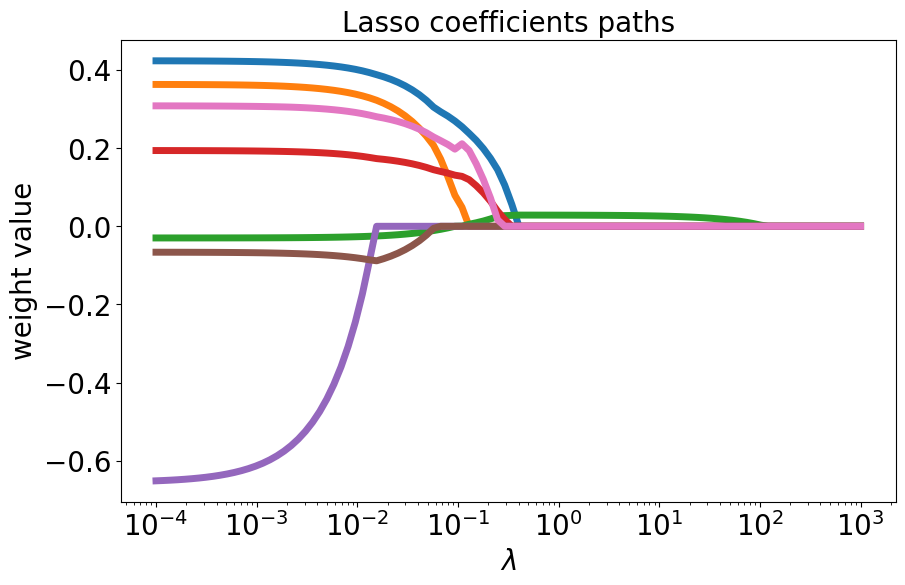

In [32]:
plt.figure(figsize=(10,6))

ax = plt.gca()
ax.plot(alphas, coef_lasso, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.ylabel('weight value', fontsize=font)
plt.title('Lasso coefficients paths', fontsize=font)
plt.show()

Vemos cómo según el valor de $\lambda$ incrementa algunas variables en concreto son eliminadas debido a que sus coeficientes se vuelven 0.

## Elastic net

[ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#elasticnet)

In [33]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 1, l1_ratio = 0.5)
elastic_net.fit(X_train, y_train)

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test)))

Train MSE: 0.6375
Test MSE: 3.5183


In [40]:
coef_eln = []
err_eln = []
baseline = []
for a in alphas:
    elastic_net = ElasticNet(alpha = a, l1_ratio=1)
    elastic_net.fit(X_train, y_train)
    coef_eln.append(elastic_net.coef_)
    y_pred = elastic_net.predict(X_test)
    elasticnet_error = metrics.mean_squared_error(y_pred, y_test)
    err_eln.append(elasticnet_error)
    baseline.append(baseline_error)
    

In [44]:
min(err_eln)

np.float64(1.8512304850728976)

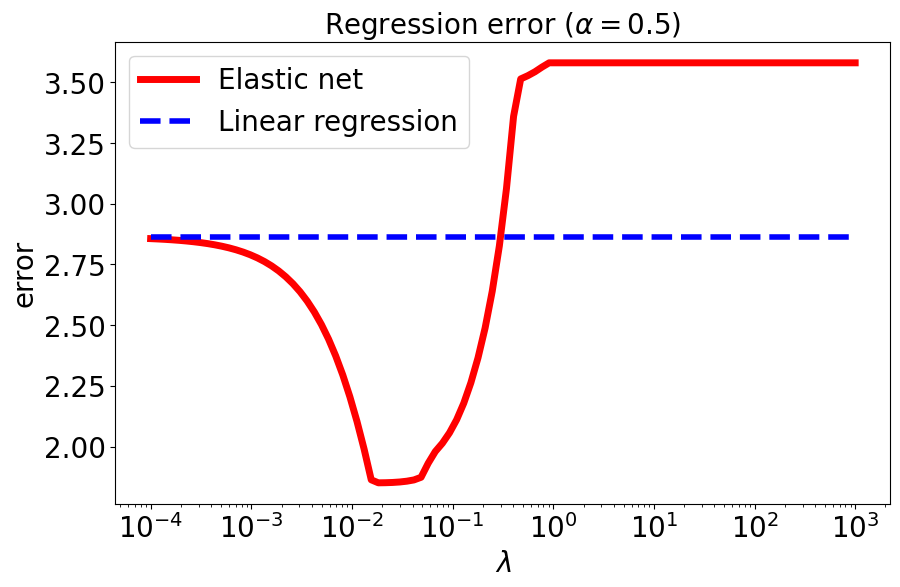

In [37]:
plt.figure(figsize=(10,6))

ax = plt.gca()
ax.plot(alphas, err_eln, linewidth=5, color='red', label="Elastic net")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.ylabel('error', fontsize=font)
ax.legend(fontsize=font)
plt.title(r'Regression error ($\alpha=0.5$)', fontsize=font)
plt.show()

In [38]:
elastic_net = ElasticNet(alpha = 0.02, l1_ratio=1)
elastic_net.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test)))

Train MSE: 0.3061
Test MSE: 1.8514


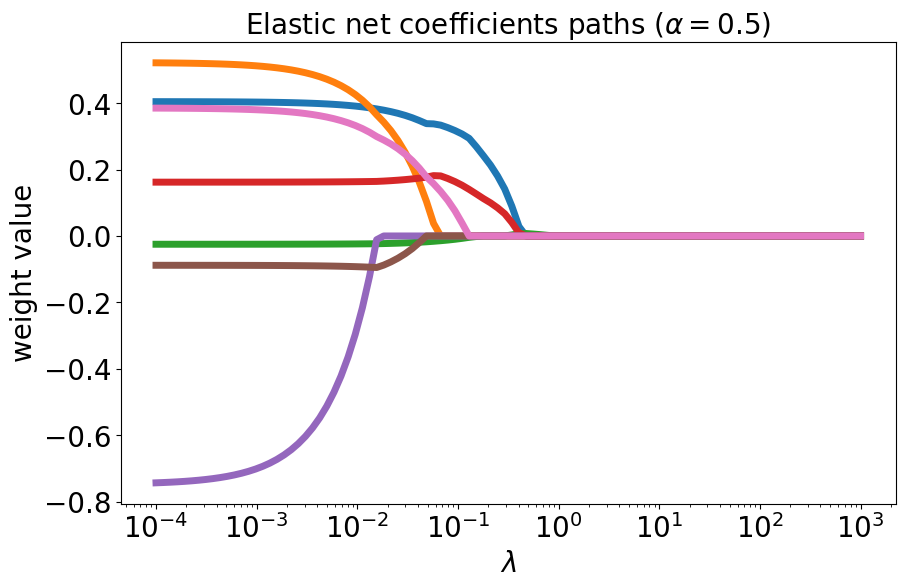

In [39]:
plt.figure(figsize=(10,6))

ax = plt.gca()
ax.plot(alphas, coef_eln, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.ylabel('weight value', fontsize=font)
plt.title(r'Elastic net coefficients paths ($\alpha=0.5$)', fontsize=font)
plt.show()

# Selección del modelo 

In [45]:
print("Linear regression error:   %0.4f" % baseline_error)    
print("Minimun ridge error:       %0.4f" % min(err_ridge))
print("Minimum lasso error:       %0.4f" % min(err_lasso))
print("Minimum elastic net error: %0.4f" % min(err_eln))

Linear regression error:   2.8641
Minimun ridge error:       2.0651
Minimum lasso error:       1.8531
Minimum elastic net error: 1.8512


De cara a hacer más sistemática la búsqueda de valores para la regularización, existen implementaciones que incluyen la validación cruzada para los tres modelos:

* [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#ridgecv)
* [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#lassocv)
* [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#elasticnetcv)

# Validación cruzada

Es la práctica que nos permite encontrar parametrizaciones no sesgadas a una separación de _train_ y _test_ concreta.

![cross-validation](../Regresión%20lineal/img/grid_search_cross_validation.png)

Esta imagen muestra como se realizaría una validación cruzada _k_ veces (_k_-fold) de cara a que el promedio refleje una parametrización objetiva para nuestro modelo.  

https://scikit-learn.org/stable/modules/cross_validation.html